In [1]:
import numpy as np
import pandas as pd
import gzip
import json
import datetime
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pprint import pprint

In [2]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train_classification_df = pd.read_csv("train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [4]:
# stats about the labels
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [5]:
username2_category["kod8net"]

'tech'

In [8]:
train_data_path = "training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [9]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


  --Using the TfidfVectorizer (with Turkish stopwords and a max_features limit of **5000**), the code builds a vocabulary based on how often words appear. Each user’s combined text becomes a row in a sparse TF-IDF matrix, and each word in the vocabulary is a column. The numeric values in the matrix show how important each word is for that user compared to its usage across all users.Users labeled in username2_category form the training set **(x_post_train)**, and unlabeled users become the test set **(x_post_test)**. We only fit the vectorizer on the training corpus, then use the same vocabulary to transform test data to maintain consistency. Finally, we assemble a DataFrame **(df_tfidf)** to inspect the TF-IDF values for each word, confirming our feature extraction worked properly.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [11]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [12]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      dtype=object)

In [13]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,abdullah,abone,about,acele,acil,activities,acı,ad,ada,adam,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050596,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [14]:
df_tfidf.shape

(2741, 5000)

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [16]:
x_train.shape

(2192, 5000)

In [17]:
x_val.shape

(549, 5000)

  --The **log_mse_like_counts** function computes a special kind of error based on the logarithm of values. If we want to predict how many likes a post will get, we can transform actual and predicted counts by **log1p** (log of one plus the count). We then calculate the mean of the squared differences. This approach penalizes large errors less drastically than a simple mean squared error on raw counts and is often useful when dealing with data that spans several orders of magnitude.

In [18]:
def log_mse_like_counts(y_true, y_pred):
    """
    Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)

    squared_errors = (log_y_true - log_y_pred) ** 2
    return np.mean(squared_errors)

  --The function get_time_weighted_likes computes an average “time-weighted” like count for a list of posts. It is especially useful if we want to emphasize recent posts more than older posts when calculating the average likes. By focusing on how recently each post was published, this function provides a more dynamic view of user engagement.Inside the function, it first checks if we have any posts. If there are none, it simply returns 0.0. It then determines a reference point in time called current_time, which is the timestamp of the most recent post in the list or the timestamp of a **current_post **if provided.For each post, we skip over the same post if **current_post** is specified (to avoid double-counting). Then, we calculate how many days have passed since that post was created **(time_diff_days).** The weight for each post’s like count is computed as **2-(time_diff_days/15)**, meaning the post’s influence is cut in half roughly every 15 days. This ensures that older posts contribute less to the final average. After adding up all weighted like counts and their corresponding weights, we divide **total_weighted_likes** by **total_weights**. If there were no valid timestamps or weights, we return 0.0. This result is a single float value representing the “time-weighted” average likes, with more recent posts having a greater impact.

In [19]:
def get_time_weighted_likes(posts: list, current_post: dict = None) -> float:
        if not posts:
            return 0.0

        if current_post is None:
            current_time = parse_timestamp(posts[-1]["timestamp"])
        else:
            current_time = parse_timestamp(current_post["timestamp"])

        if current_time is None:
            return 0.0

        total_weighted_likes = 0.0
        total_weights = 0.0

        for post in posts:
            if current_post is not None and post["id"] == current_post["id"]:
                continue

            like_count = post.get("like_count", 0)
            if like_count is None:
                like_count = 0

            try:
                post_time = parse_timestamp(post["timestamp"])
                if post_time is None:
                    continue

                time_diff_days = abs((current_time - post_time).days)

                # Adjust weight calculation to focus more on recent posts
                weight = 2 ** (-time_diff_days / 15)  # Reduced half-life to 15 days

                total_weighted_likes += like_count * weight
                total_weights += weight

            except (ValueError, TypeError):
                total_weighted_likes += like_count * 0.1
                total_weights += 0.1

        if total_weights == 0:
            return 0.0

        return total_weighted_likes / total_weights

  --This function, **parse_timestamp**, converts various timestamp formats into a Python datetime object. It first checks if the timestamp is an integer or a float and treats it as a Unix timestamp (seconds since the epoch). If it's a string, it attempts to parse it in the format YYYY-MM-DD HH:MM:SS. If that fails, it tries to interpret the string as a Unix timestamp. In any case where the timestamp is invalid or not recognized, the function returns None instead.

In [20]:
def parse_timestamp(timestamp):
    """Handle both string and float timestamp formats"""
    if isinstance(timestamp, (int, float)):
        return datetime.fromtimestamp(timestamp)
    elif isinstance(timestamp, str):
        try:
            return datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            # Try parsing as Unix timestamp if string format fails
            return datetime.fromtimestamp(float(timestamp))
    return None

This function, **convert_to_serializable**, ensures that objects with NumPy-specific data types (like np.integer or np.floating) are converted into regular Python integers or floats. If the object is a NumPy array (np.ndarray), the function transforms it into a Python list. This conversion is particularly helpful when you need to serialize data into formats like JSON, which doesn’t recognize NumPy types natively.

In [21]:
def convert_to_serializable(obj):
    """Convert numpy types to Python native types"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


  --This function, **extract_enhanced_features**, gathers various details from a given Instagram post and the user’s history to produce a feature vector for modeling. It starts by parsing the post’s timestamp to extract time features (hour, weekday, month). It then computes user-level statistics like average likes, standard deviation, maximum likes, and a time-weighted average of likes. The function also captures account details (follower count, verified status) and post-specific traits (media type, recent likes, and content length). All these elements are combined into a NumPy array, forming a rich set of features suitable for models like XGBoost.

In [22]:
def extract_enhanced_features(post, user_posts):
    """Extract richer feature set for XGBoost"""
    current_time = parse_timestamp(post["timestamp"])

    # Time features
    hour = current_time.hour
    day = current_time.weekday()
    month = current_time.month

    # User history features
    historical_likes = [p.get("like_count", 0) or 0 for p in user_posts]
    user_avg_likes = np.mean(historical_likes) if historical_likes else 0
    user_std_likes = np.std(historical_likes) if len(historical_likes) > 1 else 0
    user_max_likes = max(historical_likes) if historical_likes else 0
    user_weighted_likes = get_time_weighted_likes(user_posts, post)
    user_verified = 1 if post.get("user_verified", False) else 0
    user_follower_count = post.get("user_follower_count", 0) or 0
    media_type = post.get("media_type", "")  # Get media type from post
    is_video = 1 if media_type == "VIDEO" else 0
    is_image = 1 if media_type == "IMAGE" else 0
    is_carousel = 1 if media_type == "CAROUSEL_ALBUM" else 0


    # Rolling statistics (last 5 posts)
    recent_likes = historical_likes[-5:]
    rolling_avg = np.mean(recent_likes) if recent_likes else 0

    features = [
        is_video,
        is_image,
        is_carousel,
        user_follower_count,
        user_avg_likes,
        user_std_likes,
        user_max_likes,
        rolling_avg,
        user_weighted_likes,
        hour,
        day,
        user_verified,
        month,
        len(user_posts),  # Activity level
        len(post.get("text", "")) if "text" in post else 0,  # Content length
    ]
    return np.array(features)


This function, **train_xgboost_model**, builds and trains an XGBoost regression model for predicting log-transformed “likes.” It loops through each user’s posts, extracting a numeric feature vector using extract_enhanced_features and taking the natural log of likes as the label (y_train). After transforming these lists to NumPy arrays, it creates an XGBRegressor with specified hyperparameters (like **max_depth** and **learning_rate**) and fits it on the feature matrix **X_train** and the target values **y_train**. The function then returns the trained model.

In [23]:
def train_xgboost_model(username2posts_train):
    """Train XGBoost model with optimized parameters"""
    X_train, y_train = [], []

    for username, posts in username2posts_train.items():
        for post in posts:
            X_train.append(extract_enhanced_features(post, posts))
            y_train.append(np.log1p(post.get("like_count", 0) or 0))

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )

    model.fit(X_train, y_train)
    return model

  --This code starts by training a global XGBoost model (via **train_xgboost_model**) to predict the number of likes on an Instagram post. Once the model is trained, the function predict_like_count takes a username and optionally a specific post. It then extracts numerical features (using extract_enhanced_features) and calls the model to obtain a log-likes prediction, which it exponentiates and subtracts 1 to get a regular like count.

  --The **evaluate_model** function runs through both the training and test sets, predicting likes for every post and comparing them with the actual like counts. Using the **log_mse_like_counts** function, it calculates the average log-based mean squared error (Log MSE). The results show a Log MSE of approximately 0.522 on the training set and 0.584 on the test set, indicating a reasonable increase in error when moving from training to test data. Finally, the code prints out the number of samples in each dataset, confirming that thousands of posts (94,824 for training and 92,478 for testing) were used in evaluating the model’s performance.

In [24]:
def predict_like_count(username, current_post=None):
    """Predict like count using XGBoost"""
    if username not in username2posts_train and username not in username2posts_test:
        return 0

    user_posts = username2posts_train.get(username, username2posts_test.get(username, []))

    if current_post is None:
        features = extract_enhanced_features(user_posts[-1], user_posts)
    else:
        features = extract_enhanced_features(current_post, user_posts)

    prediction = model.predict([features])[0]
    return np.exp(prediction) - 1

# Train model globally
model = train_xgboost_model(username2posts_train)


def evaluate_model(output_file=None):
    # Initialize lists for true and predicted values
    y_like_count_train_true = []
    y_like_count_train_pred = []
    y_like_count_test_true = []
    y_like_count_test_pred = []

    # Training set evaluation
    for uname, posts in username2posts_train.items():
        for post in posts:
            pred_val = predict_like_count(uname, post)
            true_val = post.get("like_count", 0)
            if true_val is None:
                true_val = 0

            y_like_count_train_true.append(true_val)
            y_like_count_train_pred.append(pred_val)

    # Test set evaluation
    for uname, posts in username2posts_test.items():
        for post in posts:
            pred_val = predict_like_count(uname, post)
            true_val = post.get("like_count", 0)
            if true_val is None:
                true_val = 0

            y_like_count_test_true.append(true_val)
            y_like_count_test_pred.append(pred_val)

    # Calculate metrics
    train_log_mse = log_mse_like_counts(y_like_count_train_true, y_like_count_train_pred)
    test_log_mse = log_mse_like_counts(y_like_count_test_true, y_like_count_test_pred)

    print(f"Log MSE Train = {train_log_mse:.6f}")
    print(f"Log MSE Test  = {test_log_mse:.6f}")

    # Additional statistics
    print("\nDataset Statistics:")
    print(f"Training samples: {len(y_like_count_train_true)}")
    print(f"Test samples: {len(y_like_count_test_true)}")


evaluate_model("prediction-regression-round1.json")

Log MSE Train = 0.522057
Log MSE Test  = 0.584344

Dataset Statistics:
Training samples: 94824
Test samples: 92478


  --This function, predict_for_test, reads a JSON lines file containing test posts (test-regression-round.jsonl) and uses the previously trained model to predict like counts for each post. It rounds these predictions to the nearest integer and ensures the result is non-negative. Finally, it writes all predictions to a new JSON file (prediction-regression-round.json) so they can be further analyzed or submitted as final model output

In [25]:
def predict_for_test():
    predictions = {}
    with open('test-regression-round3.jsonl', 'r') as f:
        for line in f:
            post = json.loads(line)
            pred = predict_like_count(post["username"], post)
            predictions[post["id"]] = max(0, round(pred))

    with open('prediction-regression-round3.json', 'w') as outf:
        json.dump(predictions, outf, indent='\t')

predict_for_test()

In [26]:
with open('prediction-regression-round3.json', 'r') as f:
    predictions = json.load(f)
print(f"Number of predictions: {len(predictions)}")

Number of predictions: 3000


In [27]:
count = 0
with open('test-regression-round3.jsonl', 'r') as f:
    for line in f:
        count += 1
print(f"Total number of posts: {count}")

Total number of posts: 3000


This check_duplicates function opens and loads predictions from the file prediction-regression-round.json, then compares the number of unique post IDs against the total number of entries. If there’s a mismatch, it indicates duplicated keys. In this case, the function prints “No duplicates found” and returns False, confirming that every prediction ID is unique.

In [28]:
def check_duplicates():
    with open('prediction-regression-round3.json', 'r') as f:
        predictions = json.load(f)
        unique_ids = set(predictions.keys())

        if len(unique_ids) != len(predictions):
            print(f"Duplicates found - unique IDs: {len(unique_ids)}, total IDs: {len(predictions)}")
            return True

    print("No duplicates found")
    return False

check_duplicates()

No duplicates found


False

  --This code provides a thorough exploration of which features from an XGBoost model matter most for predicting like counts on Instagram posts. After importing libraries such as NumPy, pandas, Matplotlib, and Seaborn, the function **analyze_feature_importance** is defined to carry out the analysis. It takes a trained XGBoost model and an optional output_file parameter for saving results. Inside the function, we start by listing the feature names in the same order that they are fed into the model: indicators for media type (**is_video**, **is_image**, **is_carousel**), user-level statistics (**user_follower_coun**t, **user_avg_likes**, **user_std_likes**), and post-level attributes (**hour**, **day**, **month**, **post_count**, and **content_length**). The model’s built-in attribute feature_importances_ gives us a score for each feature, which we transform into a pandas DataFrame and sort from most important to least important. We also convert the raw importance scores to percentages for easier interpretation.


  --In this particular example, the output shows that **user_weighted_likes** (49.62%), **rolling_avg** (23.67%), and **user_avg_likes** (16.42%) take the top spots—indicating that historical engagement patterns, especially recent ones, are the strongest predictors for new posts’ like counts. Meanwhile, features like **user_verified** or **user_follower_count** appear to contribute little or no additional predictive power in this dataset, possibly because the variance in user engagement is already captured by the primary engagement metrics. The code prints a formatted table showing each feature’s relative importance and generates a bar plot for quick visual comparison. If an output file is provided, it saves a high-resolution PNG of the plot and writes the DataFrame to a CSV for later reference. Finally, the function returns the sorted feature-importance DataFrame, making it easy to continue the analysis or reporting of results.


Feature Importance Analysis:
--------------------------------------------------
user_weighted_likes  : 48.85%
rolling_avg          : 23.83%
user_avg_likes       : 17.01%
user_std_likes       : 2.28%
is_carousel          : 1.53%
user_max_likes       : 1.49%
is_image             : 1.44%
is_video             : 1.34%
month                : 0.76%
hour                 : 0.58%
day                  : 0.56%
post_count           : 0.32%
user_follower_count  : 0.00%
user_verified        : 0.00%
content_length       : 0.00%

Results saved to feature_importance_results_plot.png and feature_importance_results_data.csv


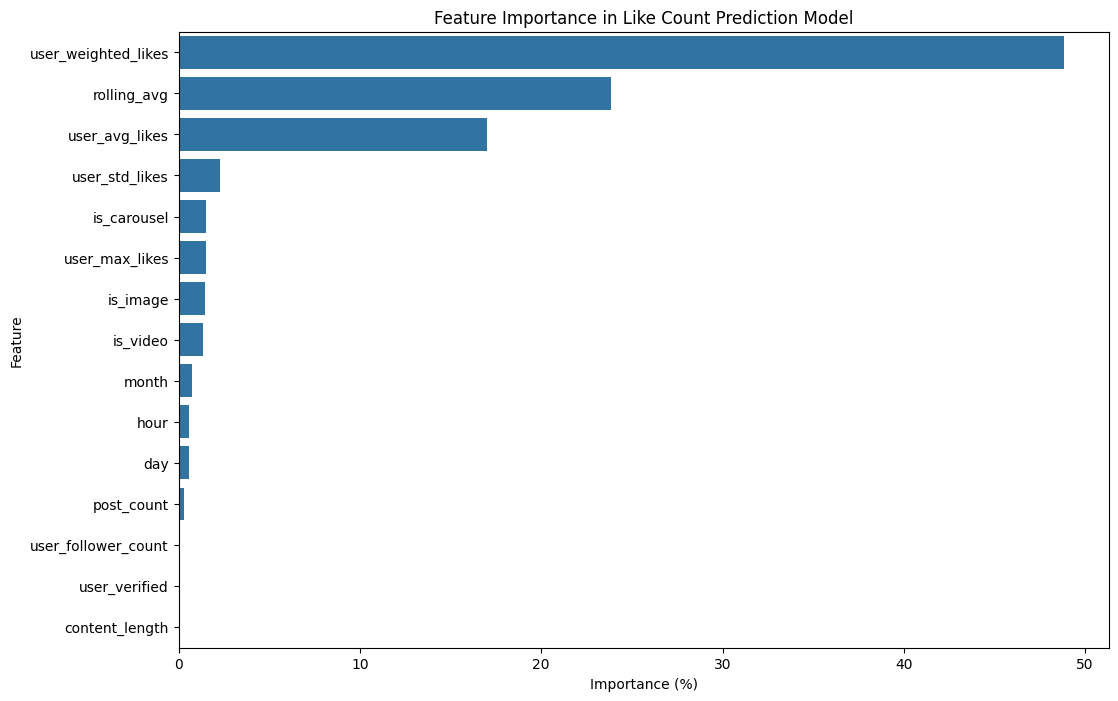

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_feature_importance(model, output_file=None):
    """
    Analyze and visualize feature importance from the XGBoost model

    Parameters:
    model: trained XGBoost model
    output_file: optional file path to save results
    """
    # Define feature names in the same order as they appear in the feature vector
    feature_names = [
        'is_video',
        'is_image',
        'is_carousel',
        'user_follower_count',
        'user_avg_likes',
        'user_std_likes',
        'user_max_likes',
        'rolling_avg',
        'user_weighted_likes',
        'hour',
        'day',
        'user_verified',
        'month',
        'post_count',
        'content_length'
    ]

    # Get feature importance scores
    importance_scores = model.feature_importances_

    # Create a DataFrame with feature names and their importance scores
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    })

    # Sort by importance in descending order
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Calculate percentage importance
    feature_importance['importance_percentage'] = feature_importance['importance'] * 100

    # Print results
    print("\nFeature Importance Analysis:")
    print("-" * 50)
    for idx, row in feature_importance.iterrows():
        print(f"{row['feature']:<20} : {row['importance_percentage']:.2f}%")

    # Create visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance, x='importance_percentage', y='feature')
    plt.title('Feature Importance in Like Count Prediction Model')
    plt.xlabel('Importance (%)')
    plt.ylabel('Feature')

    # Save plot if output file is specified
    if output_file:
        plt.savefig(output_file + '_plot.png', bbox_inches='tight', dpi=300)

        # Save detailed results to CSV
        feature_importance.to_csv(output_file + '_data.csv', index=False)
        print(f"\nResults saved to {output_file}_plot.png and {output_file}_data.csv")

    plt.show()

    return feature_importance

# Example usage:
importance_results = analyze_feature_importance(model, 'feature_importance_results')

Correlation heatmap saved to like_prediction_correlation_heatmap.png


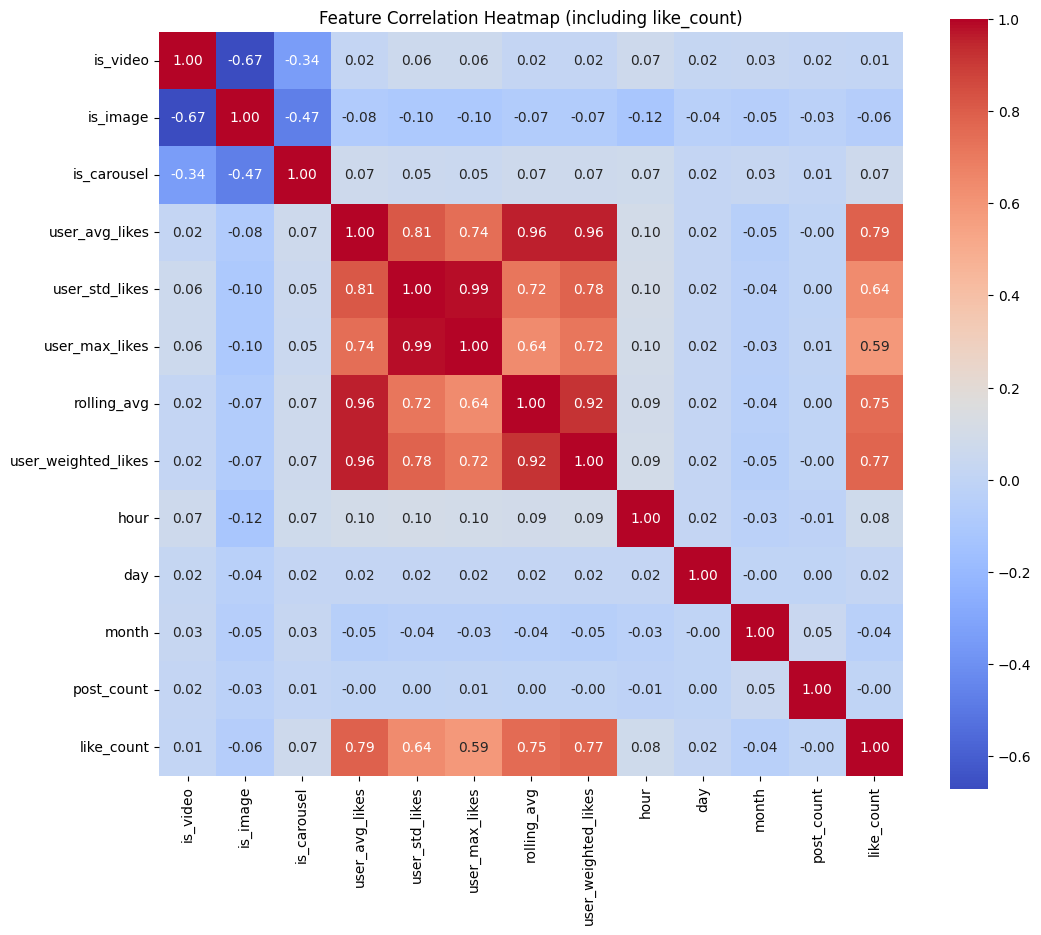

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_feature_dataframe(username2posts):
    """
    Loop over all users and their posts to build a DataFrame
    with feature columns plus the actual like_count.
    """
    data_list = []
    for username, posts in username2posts.items():
        for post in posts:
            features = extract_enhanced_features(post, posts)
            like_count = post.get("like_count", 0) or 0  # fallback if None
            data_list.append(list(features) + [like_count])

    # Match the feature order in 'extract_enhanced_features'
    columns = [
        'is_video',
        'is_image',
        'is_carousel',
        'user_follower_count',  # Will drop later
        'user_avg_likes',
        'user_std_likes',
        'user_max_likes',
        'rolling_avg',
        'user_weighted_likes',
        'hour',
        'day',
        'user_verified',        # Will drop later
        'month',
        'post_count',
        'content_length',       # Will drop later
        'like_count'            # Like count
    ]

    return pd.DataFrame(data_list, columns=columns)

def plot_feature_heatmap(df_features, output_file=None):
    # Drop unwanted columns before correlation
    cols_to_drop = ['user_follower_count', 'user_verified', 'content_length']
    df_for_corr = df_features.drop(columns=cols_to_drop, errors='ignore')

    # Compute correlation matrix
    corr_matrix = df_for_corr.corr()

    # Set up the figure
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        annot=True,          # Show correlation values
        cmap='coolwarm',     # Color map
        fmt=".2f",           # Format for correlation coefficient values
        square=True
    )
    plt.title("Feature Correlation Heatmap (including like_count)")


    # Save to file if specified
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"Correlation heatmap saved to {output_file}")

    plt.show()

# 1. Create a DataFrame of features from your training data
df_features = create_feature_dataframe(username2posts_train)

# 2. Plot the heatmap excluding the specified columns
plot_feature_heatmap(df_features, output_file="like_prediction_correlation_heatmap.png")
